In [1]:
import sys
import warnings
import gym
import typing
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from gym.envs.toy_text.blackjack import sum_hand
from collections import defaultdict
from gym.envs.toy_text.blackjack import BlackjackEnv
from gym import spaces
from gym.envs.toy_text.blackjack import (
    cmp, is_bust, is_natural, score, sum_hand
)

warnings.filterwarnings('ignore')

In [2]:
env = gym.make('Blackjack-v0')

In [3]:
env.action_space

Discrete(2)

Пространство действий интуитивно понятное:
есть 2 действия 
* hit=1 - взять еще одну карту
* stand=0 - не брать больше карт


In [4]:
env.observation_space

Tuple(Discrete(32), Discrete(11), Discrete(2))

Посмотрим на рандомную стратегию

In [5]:
class GameSim:

    def __init__(self, env, strategy, seed=None):
        self.env = env
        self.strategy = strategy
        self.seed = seed or 42
        self.train_rewards = {}
       
    def generate_episode(self, is_learn=True):
        state = self.env.reset()
        states, actions, rewards = [state], [], [0]
        is_done = False
        while True:
            action = self.strategy(state, is_learn)
            new_state, reward, is_done, info = self.env.step(action)
            if is_learn:
                self.strategy.update(state, new_state, action, reward)
            state = new_state

            states.append(state)
            actions.append(action)
            rewards.append(reward)

            if is_done:
              break

        return states, actions, rewards
    
    def reset(self):
        self.env.seed(self.seed)
        self.train_rewards = {}
    
    def train(self, num_episodes=10_000):
        self.reset()
        for i in tqdm(range(num_episodes), desc="fit: "):
            states, actions, rewards = self.generate_episode(is_learn=True)
            
    def eval_reward(self, num_episodes=10_000, is_plot_mean=True):
        total_reward = 0

        mean_rewards = []
        _rewards = []
        for i in tqdm(range(num_episodes), desc='calc reward: '):
            _, _, rewards = self.generate_episode(is_learn=False)
            total_reward += rewards[-1]
            _rewards.append(rewards[-1])

            mean_rewards.append(np.mean(_rewards))

        if is_plot_mean:
            ax = sns.scatterplot(range(len(mean_rewards)), mean_rewards)
            ax.set(
                xlabel="#episodes",
                ylabel="Средний выгрыш",
                title="Динамика среднего выгрыша"
            )
            plt.show()
        return total_reward / num_episodes

In [6]:
class SimpleStrategy:
    def __call__(self, state, exploration):
        return state[0] < 19
    
    def update(self, state, new_state, action, reward):
        pass

class RandomStrategy:

    def __init__(self, env):
      self.env = env

    def __call__(self, state, exploration):
      return env.action_space.sample()

    def update(self, state, new_state, action, reward):
      pass

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

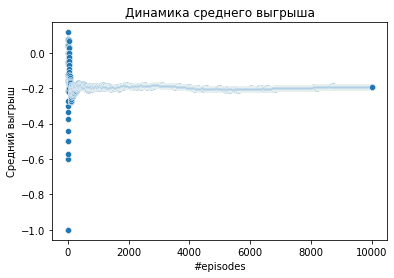

-0.1937

In [7]:
blackjack = GameSim(env, SimpleStrategy())
blackjack.eval_reward()

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

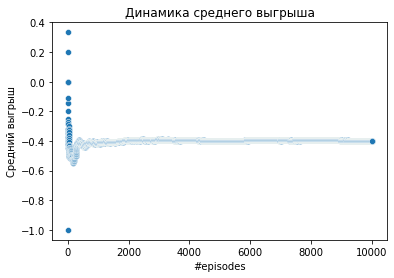

-0.3976

In [8]:
blackjack.strategy = RandomStrategy(env)
blackjack.eval_reward()

In [9]:
def first_visit_monte_carlo(game_sim, discount_rate=0.9, num_episodes=10_000):
    ns = defaultdict(int)
    values = defaultdict(float)
    
    for i in tqdm(range(num_episodes)):
        states, _, rewards = game_sim.generate_episode(is_learn=False)
        accum_rewards = 0.0
        for time_step in range(len(states) - 1, -1, -1):
            curr_reward = rewards[time_step]

            accum_rewards = discount_rate * accum_rewards + curr_reward
            
            state = states[time_step]
            ns[state] += 1
            
            if state not in states[:time_step]:
                values[state] += (accum_rewards - values[state]) / ns[state]
    return values

In [10]:
values = first_visit_monte_carlo(blackjack)
pd.DataFrame.from_dict(values, orient='index').sort_index()

  0%|          | 0/10000 [00:00<?, ?it/s]

,0
"(4, 1, False)",-0.467589
"(4, 2, False)",-0.688699
"(4, 3, False)",0.255375
"(4, 4, False)",-0.320017
"(4, 5, False)",-0.810000
...,...
"(31, 6, False)",-1.000000
"(31, 7, False)",-1.000000
"(31, 8, False)",-1.000000
"(31, 9, False)",-1.000000


2. Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но </br>рекомендую попробовать и другие, например Monte Carlo control) для обучения </br>стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.


In [11]:
class QLearning:


    def __init__(self, env, learning_rate, eps, discount_rate):
        self.env = env
        
        self.learning_rate = learning_rate
        self.eps = eps
        self.discount_rate = discount_rate
        
        self.Q = defaultdict(lambda : np.zeros(env.action_space.n))
        self.policy = defaultdict(int)
        
    def update(self, state, new_state, action, reward):
        self.Q[state][action] += self.learning_rate * (
            reward + self.discount_rate * np.max(self.Q[new_state]) 
            - self.Q[state][action]
        )
        
        self.policy[state] = np.argmax(self.Q[state])

    def __call__(self, state, exploration=True):
        if np.random.random() <= self.eps and exploration:
            return np.random.randint(self.env.action_space.n)
        return self.policy[state]
    


3. Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего </br> дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а </br>лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.


In [12]:
def grid_search(env, game_sim, strategy_cls, grid_params, episodes):
    grid = np.array(np.meshgrid(*grid_params.values())).reshape(len(grid_params), -1).T
    best_reward = -1
    best_params = {}
    for i, params in tqdm(enumerate(grid), total=len(grid), desc="GRID: "):

        params = dict(zip(grid_params.keys(), params))

        strategy = strategy_cls(env, **params)

        game_sim.strategy = strategy
        
        game_sim.train(num_episodes=episodes)

        reward = game_sim.eval_reward(num_episodes=episodes)
        
        if reward > best_reward:
            best_reward = reward
            best_params = params
    return best_reward, best_params

In [13]:
def find_best_params(env, game_sim, strategy_cls, params, num_episodes=10_000):
    best_reward, best_params = grid_search(
        env, 
        game_sim,
        strategy_cls, 
        params, 
        num_episodes
    )
    print(best_reward, best_params)
    game_sim.strategy = strategy_cls(env, **best_params)

    game_sim.train(num_episodes=num_episodes)

    game_sim.eval_reward(num_episodes=num_episodes)

In [14]:
params = {
    'learning_rate': np.linspace(1e-6, 1e-5, 3),
    'eps': np.linspace(0.7, 0.9, 3), 
    'discount_rate': np.linspace(0.9, 1, 3),
}

GRID:   0%|          | 0/27 [00:00<?, ?it/s]

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

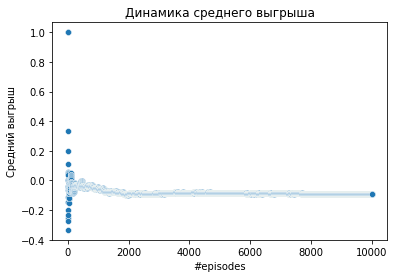

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

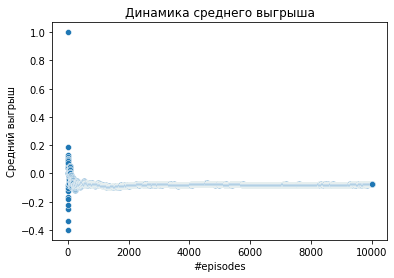

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

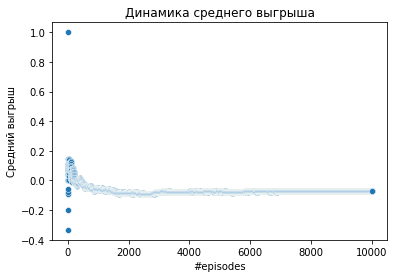

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

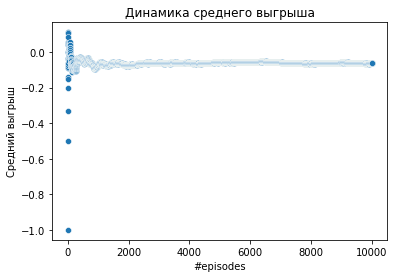

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

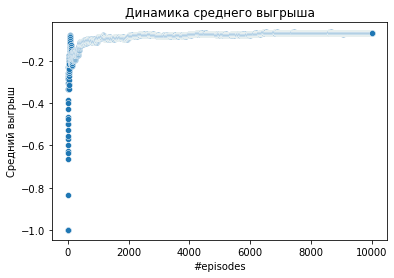

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

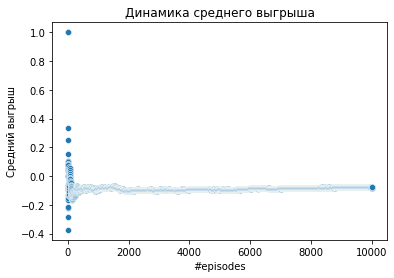

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

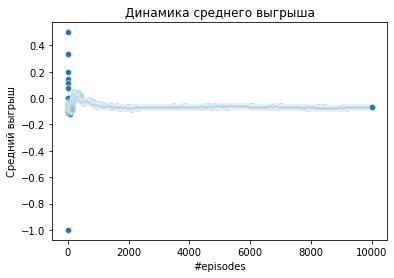

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

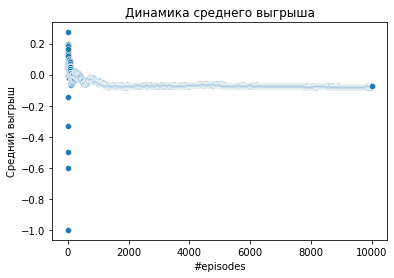

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

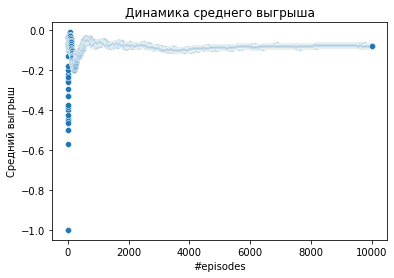

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

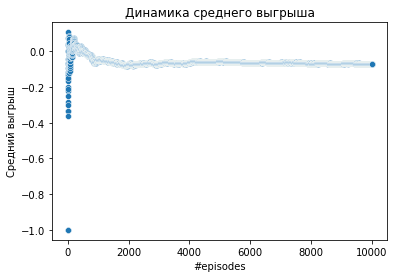

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

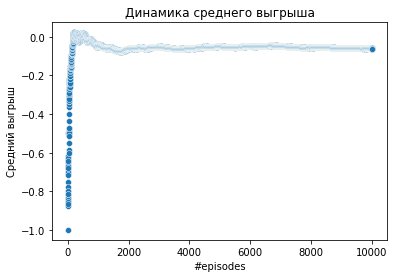

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

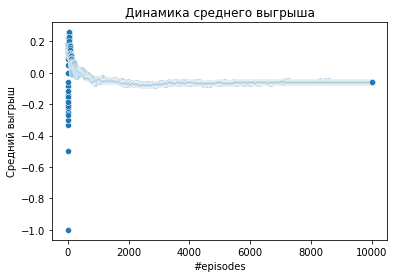

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

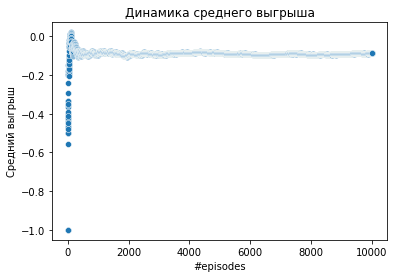

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

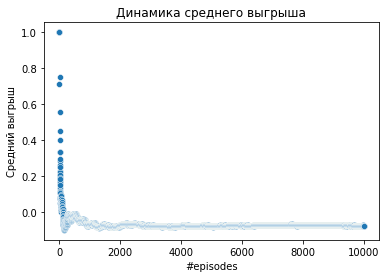

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

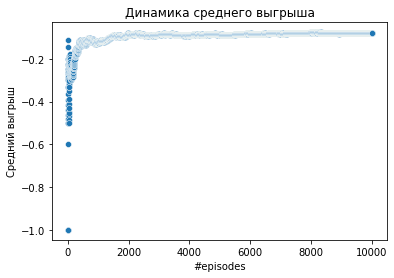

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

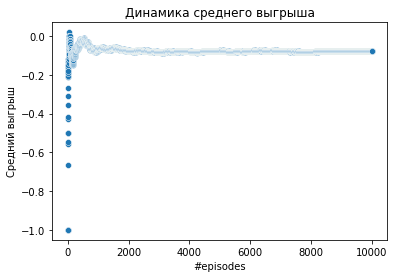

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

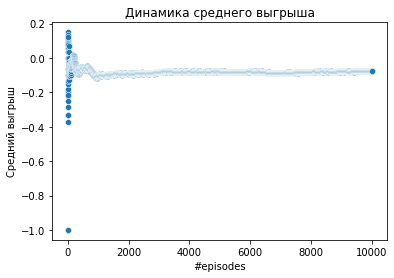

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

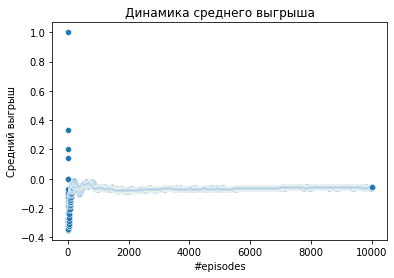

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

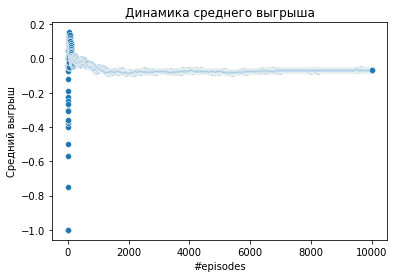

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

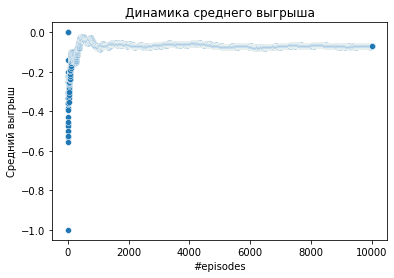

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

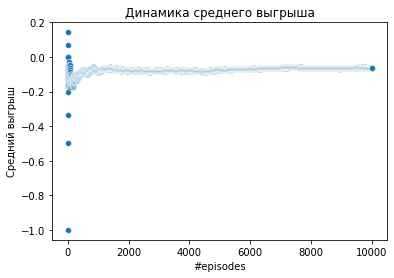

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

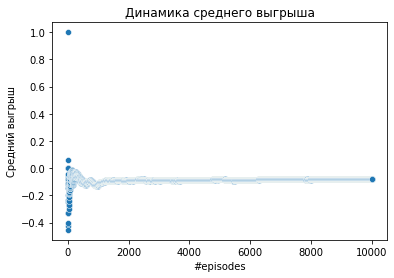

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

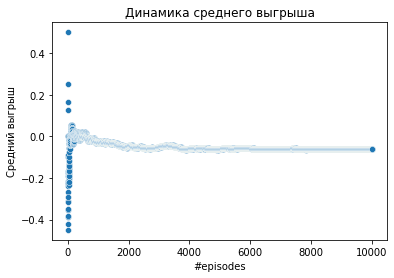

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

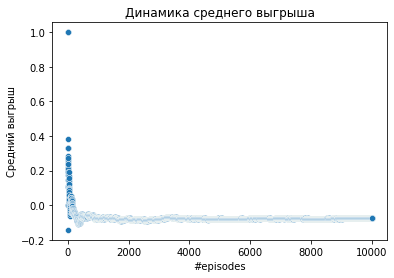

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

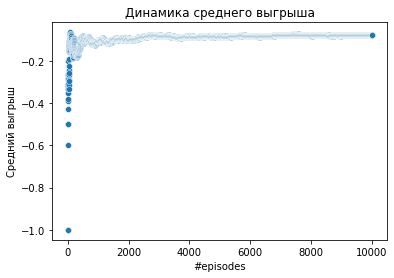

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

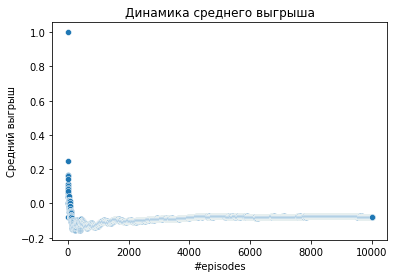

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

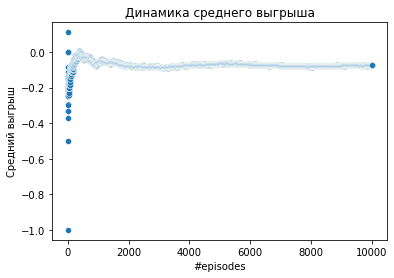

-0.0595 {'learning_rate': 5.5e-06, 'eps': 0.9, 'discount_rate': 0.95}


fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

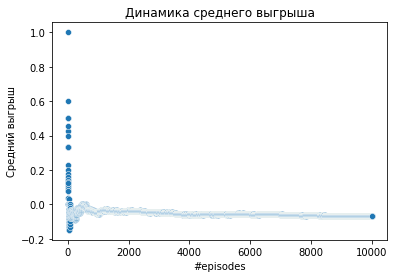

In [15]:
find_best_params(
    env, 
    game_sim=blackjack, 
    strategy_cls=QLearning, 
    params=params, 
    num_episodes=10_000
)

Часть вторая, удвоенная </br>
В базовый блекджек, описанный в предыдущем разделе, обыграть казино вряд ли </br>получится. Но, к счастью, на этом история не заканчивается. Описанные выше </br>правила были упрощёнными, а на самом деле у игрока есть ещё и другие </br>возможности. Реализовывать split может оказаться непросто, поэтому давайте </br>ограничимся удвоением ставки. Итак, у игрока появляется дополнительное действие: </br>
* double — удвоить ставку; при этом больше действий делать нельзя, игроку </br>выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается.


4. Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из </br> 
OpenAI Gym, в котором разрешено удвоение ставки

In [16]:

from gym import spaces


class DoubleBlackjackEnv(BlackjackEnv):
    def __init__(self, *args, **kwargs):
        super(DoubleBlackjackEnv, self).__init__(*args, **kwargs)
        
        self.action_space = spaces.Discrete(3)
        self.reset()
        
    def step(self, action):
        # import pdb; pdb.set_trace()
        assert self.action_space.contains(action)
        reward = max(action, 1)
        res = list(super(DoubleBlackjackEnv, self).step(min(action, 1)))
        if action == 2 and not res[2]:
            res = list(super(DoubleBlackjackEnv, self).step(0))
        res[1] *= reward
        return res

5. Реализуйте метод обучения с подкреплением без модели для этого варианта,  </br> постройте графики, аналогичные п.2.

In [17]:
blackjack = GameSim(env=DoubleBlackjackEnv(), strategy=None)

GRID:   0%|          | 0/27 [00:00<?, ?it/s]

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

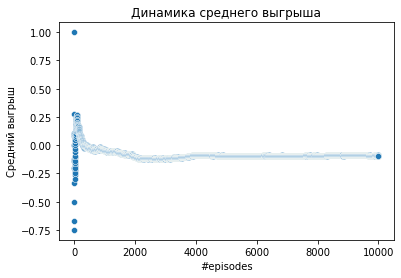

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

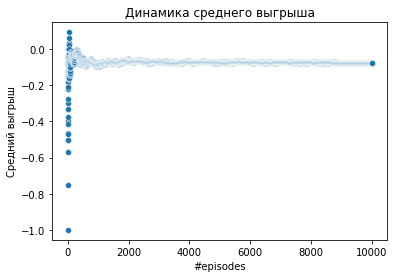

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

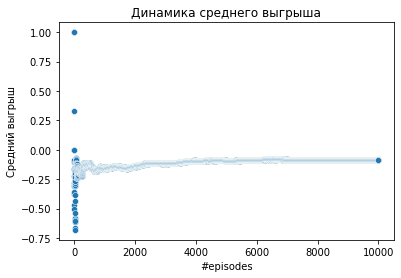

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

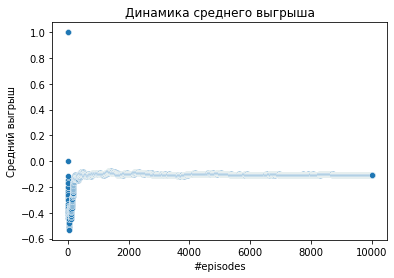

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

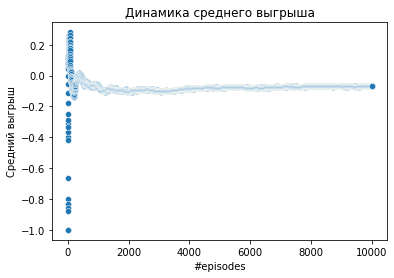

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

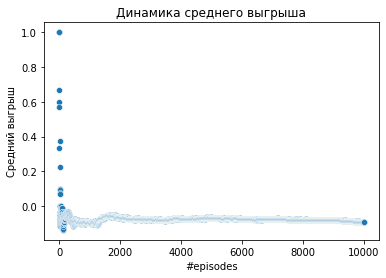

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

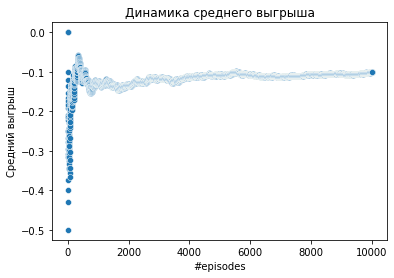

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

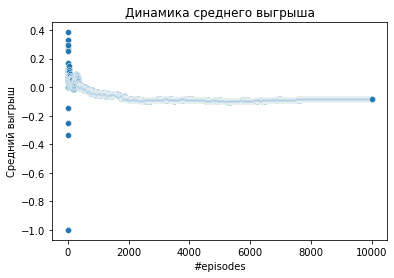

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

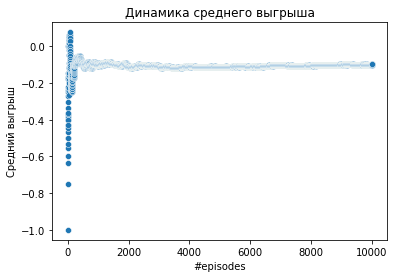

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

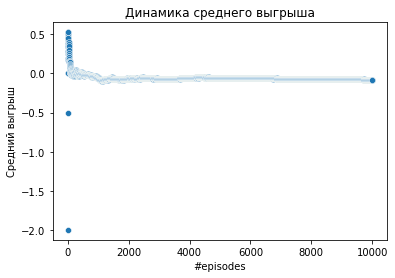

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

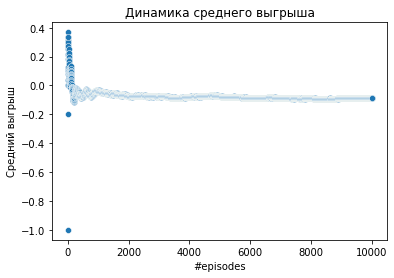

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

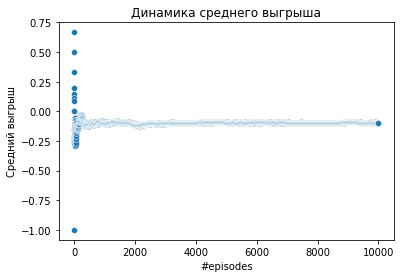

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

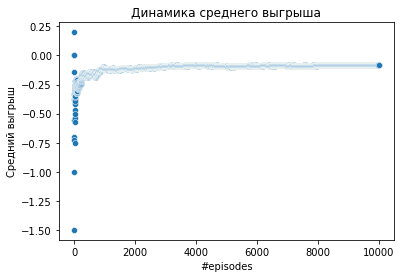

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

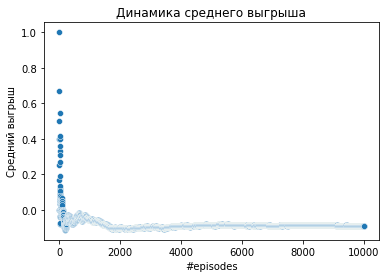

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

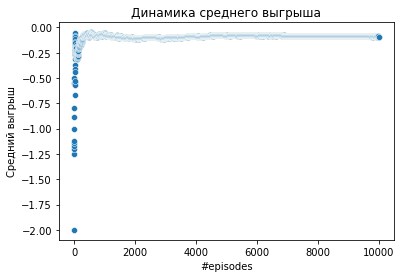

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

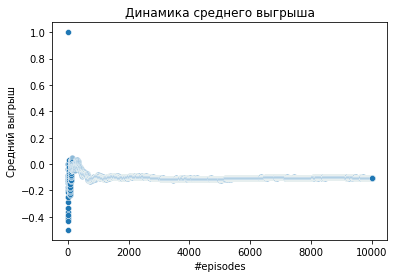

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

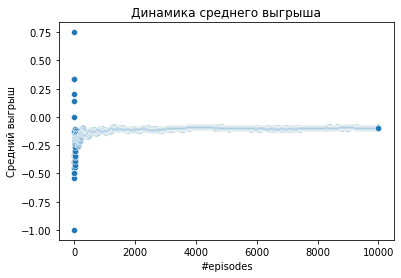

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

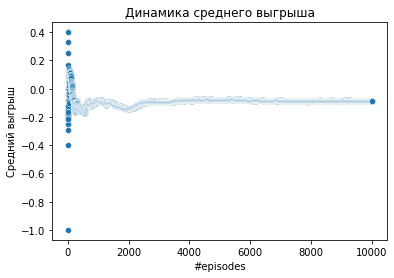

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

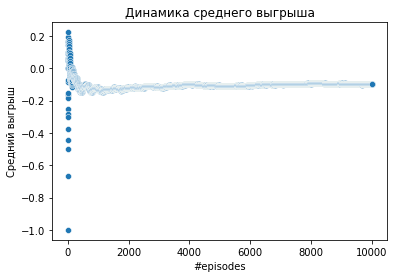

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

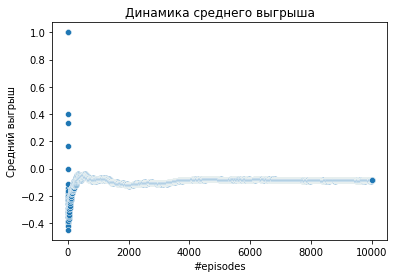

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

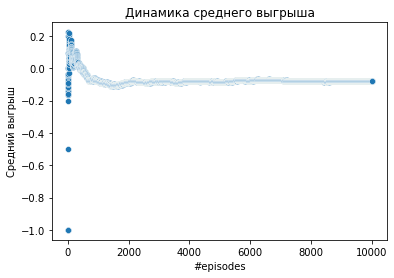

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

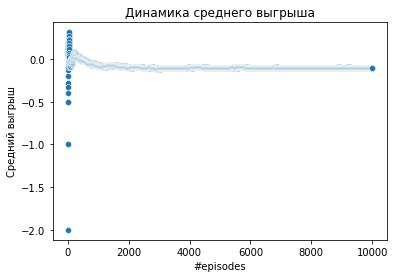

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

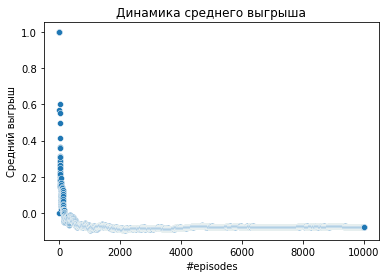

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

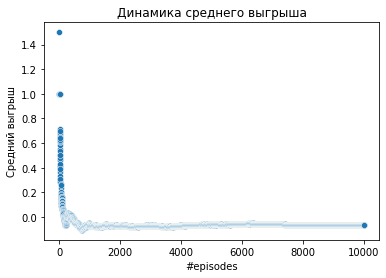

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

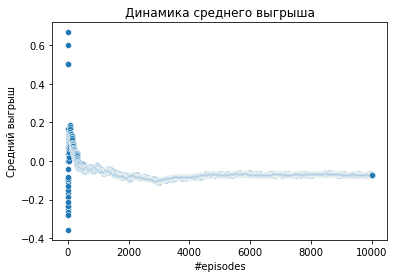

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

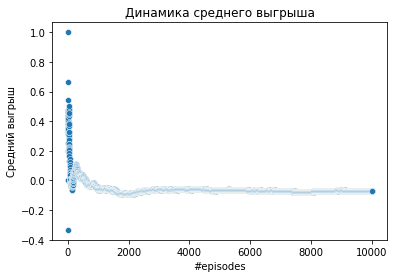

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

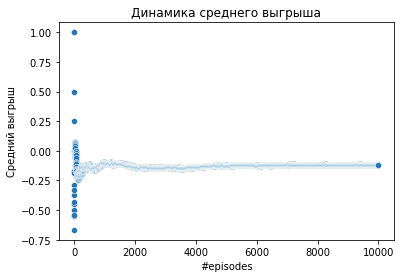

-0.0665 {'learning_rate': 5.5e-06, 'eps': 0.7, 'discount_rate': 0.95}


fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

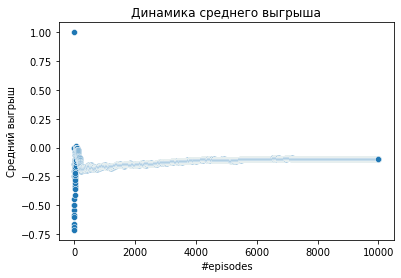

In [18]:
find_best_params(
    env=blackjack.env, 
    game_sim=blackjack, 
    strategy_cls=QLearning, 
    params=params, 
    num_episodes=10_000
)

Часть третья, в главной роли — Дастин Хоффман </br>
А теперь давайте вспомним, как играют в блекджек настоящие профессионалы. Дело </br>в том, что в оффлайн-казино обычно не перемешивают колоду после каждой </br>раздачи — это слишком замедляло бы игру. После раздачи карты просто </br>раздаются дальше с верха колоды до тех пор, пока карт не останется слишком </br>мало, и только тогда колода перемешивается; давайте для определённости </br>считать, что наше казино будет перемешивать колоду, в которой осталось меньше 15 карт.</br>
<!-- Думаю, у вас уже возникла в голове эта картинка: -->


</br>
</br>
</br>
</br>

Действительно, если вы будете запоминать, какие карты уже вышли, у вас будет </br>информация о том, какие карты ещё остались, а это позволяет лучше понять, </br>когда нужно удваивать ставку или делать split, а когда лучше не стоит. В </br>настоящем казино могут раздавать карты сразу из нескольких колод, и заслуга </br>Rain Man’а была в том, что он смог считать карты в шести колодах </br>одновременно. Но мы с вами вооружены компьютерами, так что подсчёт можно </br>считать автоматическим.


6. Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в </br>котором игрок имеет возможность “считать карты” в колоде. Это можно </br>сделать разными способами; возможно, вам поможет статья википедии о блекджеке (а возможно, и нет).</br>

Будем считать карты в колоде по системе половинки:

card	points
* 2	+0.5
* 3, 4	+1
* 5	+1.5
* 6	+1
* 7	+0.5
* 8	0
* 9	−0,5
* 10, В, Д, К, Т	−1



In [19]:
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10] * 4

cost = defaultdict(float)

cost.update({
    2: +0.5,
    3: +1,
    4: +1,
    5: +1.5,
    6: +1,
    7: +0.5,
    9: -0.5,
    10: -1,
})


In [21]:
class DoubleCountingBlackjackEnv(DoubleBlackjackEnv):

    DEALER_SUM_THRESHOLD = 17

    def __init__(self, *args, **kwargs):
        self.counter = 0
        self.deck = deck.copy()
        
        super(
            DoubleCountingBlackjackEnv, 
            self
        ).__init__(*args, **kwargs)

    def reset(self):
        if len(self.deck) <= 15:

            self.counter = 0
            self.deck = deck.copy()
        
        self.dealer = self.draw_hand()
        
        self.player = self.draw_hand()
        
        return self._get_obs()

    def step(self, action):
      assert self.action_space.contains(action)

      if action:  
          self.player.append(self.draw_card())

          if not is_bust(self.player):
              done = False
              reward = 0.
          else:
            done = True
            reward = -1.
              
      else:  
          done = True

          while sum_hand(self.dealer) < self.DEALER_SUM_THRESHOLD:
              self.dealer.append(self.draw_card())

          reward = cmp(score(self.player), score(self.dealer))
          if self.natural and is_natural(self.player) and reward == 1.:
              reward = 1.5

      return self._get_obs(), reward, done, {}
    
    def draw_hand(self):
        return [self.draw_card(), self.draw_card()]

    def draw_card(self):
        card = self.np_random.choice(self.deck)
        self.deck.remove(card)
        self.counter += cost[card]
        return int(card)

    def _get_obs(self):
        return (
            *super(DoubleCountingBlackjackEnv, self)._get_obs(), 
            self.counter
        )
    

    
 

7. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

In [22]:
blackjack = GameSim(env=DoubleCountingBlackjackEnv(), strategy=None)

GRID:   0%|          | 0/27 [00:00<?, ?it/s]

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

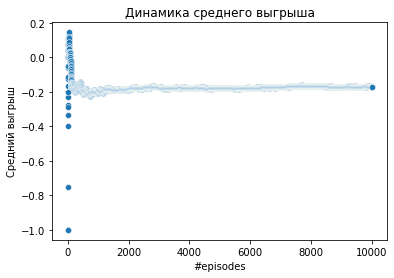

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

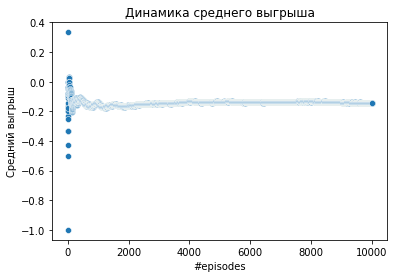

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

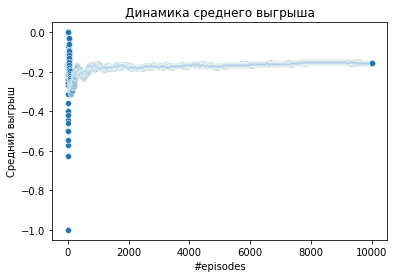

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

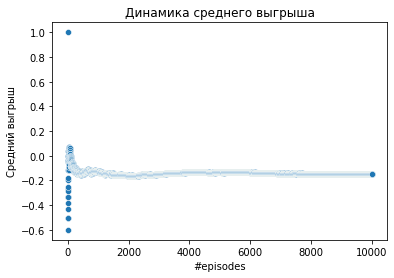

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

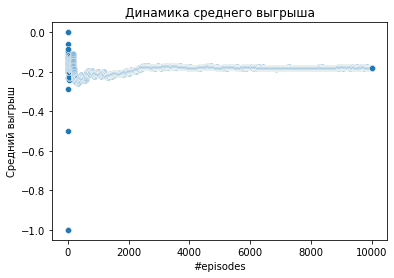

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

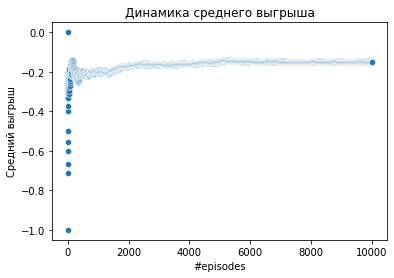

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

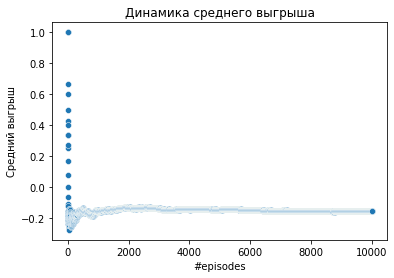

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

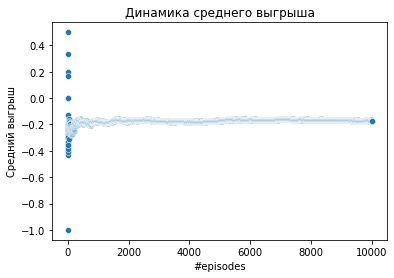

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

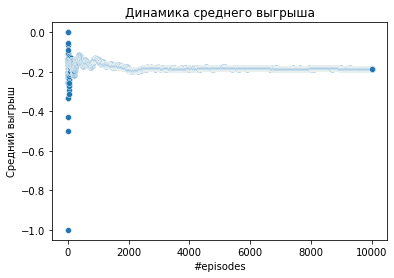

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

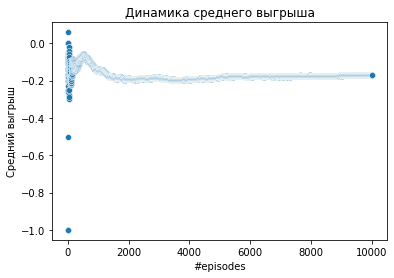

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

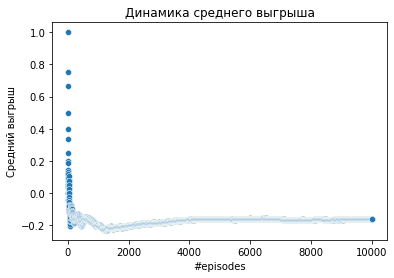

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

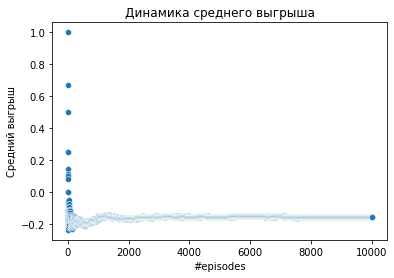

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

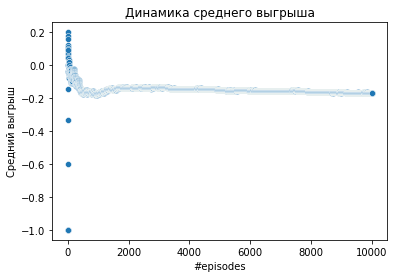

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

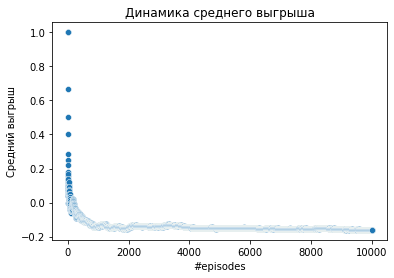

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

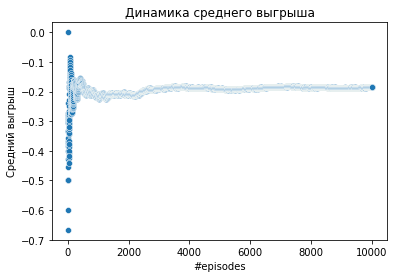

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

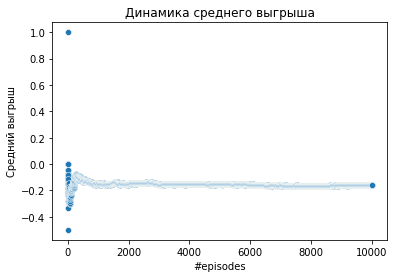

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

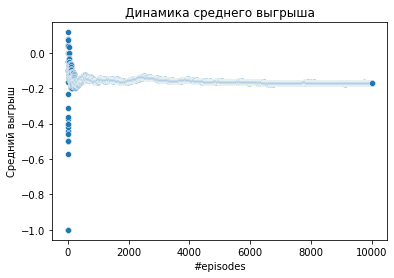

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

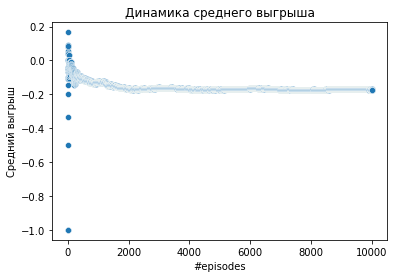

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

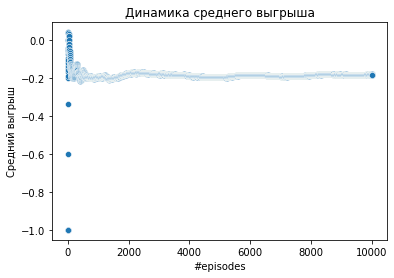

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

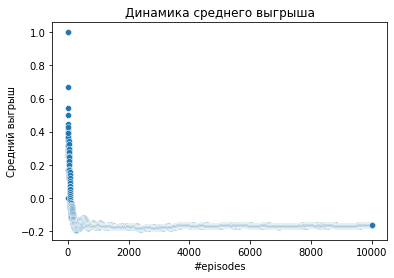

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

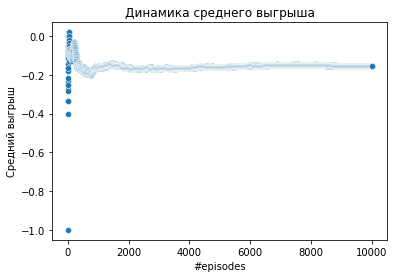

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

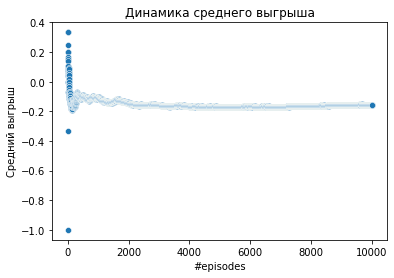

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

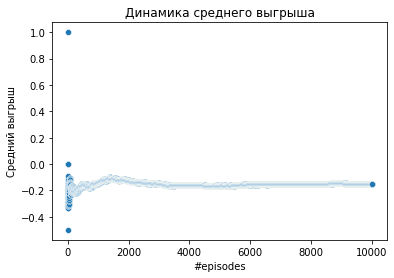

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

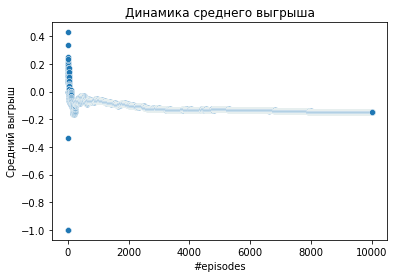

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

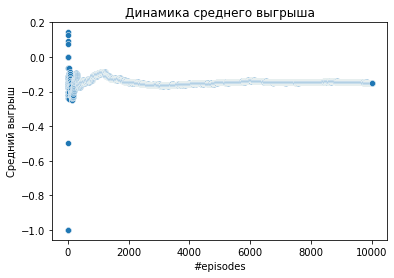

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

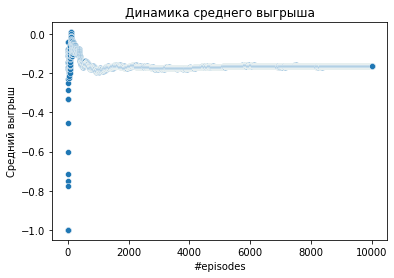

fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

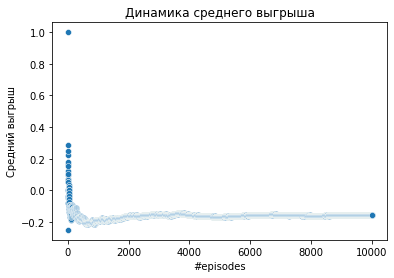

-0.1434 {'learning_rate': 1e-06, 'eps': 0.7, 'discount_rate': 0.95}


fit:   0%|          | 0/10000 [00:00<?, ?it/s]

calc reward:   0%|          | 0/10000 [00:00<?, ?it/s]

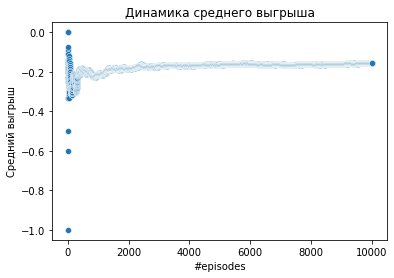

In [23]:
find_best_params(
    env=blackjack.env, 
    game_sim=blackjack, 
    strategy_cls=QLearning, 
    params=params, 
    num_episodes=10_000
)

